## Real vs Fake Faces - Model Testing

Se utilizará el conjunto de datos de "10k Real vs. Fake Faces", inicialmente destinado para el proyecto "Real vs Fake Face Detection project" del Equipo de Ciencia de Datos de Michigan. Con la proliferación de deepfakes y manipulaciones de imágenes, surge la pregunta: ¿Es posible entrenar un algoritmo de aprendizaje automático para distinguir entre rostros reales y falsos?

El objetivo de este apartado es testear diferentes modelos eligiendo como baseline un modelo convolucional simple:

In [5]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torchmetrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import random

## Carga de datos

Carga de los dataloaders generados en 2.0-dataset-transformation.ipynb

In [6]:
class FacesDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.dataframe.iloc[idx, 5])
        image = Image.open(img_name)
        label = self.dataframe.iloc[idx, 3]

        if self.transform:
            image = self.transform(image)

        return image, label

In [7]:
train_loader = torch.load('../models/notebook-train_loader.pth')
valid_loader = torch.load('../models/notebook-valid_loader.pth')

train_loader_aug = torch.load('../models/notebook-train_loader_aug.pth')
valid_loader_aug = torch.load('../models/notebook-valid_loader_aug.pth')

## Funciones

In [8]:
# Generamos el device de uso
# mps es para Macs con chip M1
# device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# cuda es para device con Nvidia
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
def train(model, optimizer, criterion, metric, data, epochs):

    train_loader = data["train"]
    valid_loader = data["valid"]

    if torch.cuda.is_available():
        model.to("cuda")
        metric.to("cuda")

    train_loss = []
    train_acc = []
    valid_loss = []
    valid_acc = []

    for epoch in range(epochs):

        # Pongo el modelo en modo entrenamiento
        model.train()

        epoch_train_loss = 0.0
        epoch_train_accuracy = 0.0

        for train_data, train_target in train_loader:

            if torch.cuda.is_available():
                train_data = train_data.to("cuda")
                train_target = train_target.to("cuda")

            optimizer.zero_grad()
            output = model(train_data.float())
            loss = criterion(output, train_target.float())
            epoch_train_loss += loss.item()
            loss.backward()
            optimizer.step()

            accuracy = metric(output, train_target)
            epoch_train_accuracy += accuracy.item()

        epoch_train_loss = epoch_train_loss / len(train_loader)
        epoch_train_accuracy = epoch_train_accuracy / len(train_loader)
        train_loss.append(epoch_train_loss)
        train_acc.append(epoch_train_accuracy)

        # Pongo el modelo en modo testeo
        model.eval()

        epoch_valid_loss = 0.0
        epoch_valid_accuracy = 0.0

        for valid_data, valid_target in valid_loader:
            if torch.cuda.is_available():
                valid_data = valid_data.to("cuda")
                valid_target = valid_target.to("cuda")

            output = model(valid_data.float())
            epoch_valid_loss += criterion(output, valid_target.float()).item()
            epoch_valid_accuracy += metric(output, valid_target.float()).item()

        epoch_valid_loss = epoch_valid_loss / len(valid_loader)
        epoch_valid_accuracy = epoch_valid_accuracy / len(valid_loader)
        valid_loss.append(epoch_valid_loss)
        valid_acc.append(epoch_valid_accuracy)

        print("Epoch: {}/{} - Train loss {:.6f} - Train Accuracy {:.6f} - Valid Loss {:.6f} - Valid Accuracy {:.6f}".format(
        epoch+1, epochs, epoch_train_loss, epoch_train_accuracy, epoch_valid_loss, epoch_valid_accuracy))

    history = {}
    history["train_loss"] = train_loss
    history["train_acc"] = train_acc
    history["valid_loss"] = valid_loss
    history["valid_acc"] = valid_acc

    return history

In [15]:
def plot_history(history):
    
    fig, axs = plt.subplots(2, 1, figsize=(10, 10))
    axs[0].plot(history["train_loss"])
    axs[0].plot(history["valid_loss"])
    axs[0].title.set_text('Error de Entrenamiento vs Validación')
    axs[0].legend(['Train', 'Valid'])

    axs[1].plot(history["train_acc"])
    axs[1].plot(history["valid_acc"])
    axs[1].title.set_text('Accuracy de Entrenamiento vs Validación')
    axs[1].legend(['Train', 'Valid'])

In [34]:
def evaluate_model(model, valid_loader, metric):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    seed = 42
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            #_, predicted = torch.max(outputs, 1)
            predicted = outputs
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # print(f'Accuracy: {accuracy_score(all_labels, all_preds)}')
    # metric_result = metric(all_preds, all_labels)
    metric_result = metric(torch.tensor(all_preds), torch.tensor(all_labels))
    print(f'Accuracy: {metric_result}')

    # report
    all_preds_binary = [1 if value > 0.5 else 0 for value in all_preds]

    print("Classification Report:")
    print(classification_report(all_labels, all_preds_binary))

    # confusion matrix
    cm = confusion_matrix(all_labels, all_preds_binary)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='g')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.show()

In [48]:
# Definimos una función que plotee los resultados
def plot_predictions(model, 
                     valid_loader, 
                     label_map = {0: 'fake', 1: 'real'}, 
                     device = device):
    plt.figure(figsize=(10, 10))
    
    images, labels = next(iter(valid_loader))
    
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    # _, predicted = torch.max(outputs, 1)
    predicted = outputs
    predicted_binary = [1 if value > 0.5 else 0 for value in predicted]

    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].cpu().permute(1, 2, 0))
        color = 'green' if predicted_binary[i] == labels[i] else 'red'
        plt.title(f'Actual: {label_map[int(labels[i])]}, Predicted: {label_map[predicted_binary[i]]}', color=color)
        plt.axis('off')

    plt.show()

## Entrenamiento de modelos

Propuesta de modelo simple.

In [13]:
class FacesSimpleCNN(nn.Module):
    def __init__(self):
        super(FacesSimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(128 * 28 * 28, 512)
        # self.fc2 = nn.Linear(512, 2)
        self.fc2 = nn.Linear(512, 1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
        self.final = torch.nn.Sigmoid()
        
    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(-1, 128 * 28 * 28)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.final(x)
        return x.squeeze()

Entrenamiento de modelo simple con dataloader sin data augmentation.

In [14]:
# cantidad_clases = 2
images_width = 224
images_height = 224
simple_model = FacesSimpleCNN()
optimizer = torch.optim.Adam(simple_model.parameters(), lr=0.0001)
# loss = torch.nn.CrossEntropyLoss()
loss = torch.nn.BCELoss()
# metric = torchmetrics.Accuracy(task='multiclass', num_classes=cantidad_clases)
metric = torchmetrics.classification.BinaryAccuracy()
data = {"train": train_loader, "valid": valid_loader, "image_width": images_width, "image_height": images_height}

history = train(simple_model,
                optimizer,
                loss,
                metric,
                data,
                10)

Epoch: 1/10 - Train loss 0.632511 - Train Accuracy 0.643598 - Valid Loss 0.564192 - Valid Accuracy 0.708001
Epoch: 2/10 - Train loss 0.543483 - Train Accuracy 0.730118 - Valid Loss 0.530199 - Valid Accuracy 0.739805
Epoch: 3/10 - Train loss 0.466847 - Train Accuracy 0.780394 - Valid Loss 0.475962 - Valid Accuracy 0.763298
Epoch: 4/10 - Train loss 0.402810 - Train Accuracy 0.820205 - Valid Loss 0.449087 - Valid Accuracy 0.793107
Epoch: 5/10 - Train loss 0.328011 - Train Accuracy 0.862300 - Valid Loss 0.415387 - Valid Accuracy 0.809176
Epoch: 6/10 - Train loss 0.261799 - Train Accuracy 0.895691 - Valid Loss 0.490697 - Valid Accuracy 0.789672
Epoch: 7/10 - Train loss 0.207728 - Train Accuracy 0.920615 - Valid Loss 0.408207 - Valid Accuracy 0.827128
Epoch: 8/10 - Train loss 0.155978 - Train Accuracy 0.943826 - Valid Loss 0.408151 - Valid Accuracy 0.833777
Epoch: 9/10 - Train loss 0.124097 - Train Accuracy 0.955337 - Valid Loss 0.446013 - Valid Accuracy 0.832890
Epoch: 10/10 - Train loss 0.

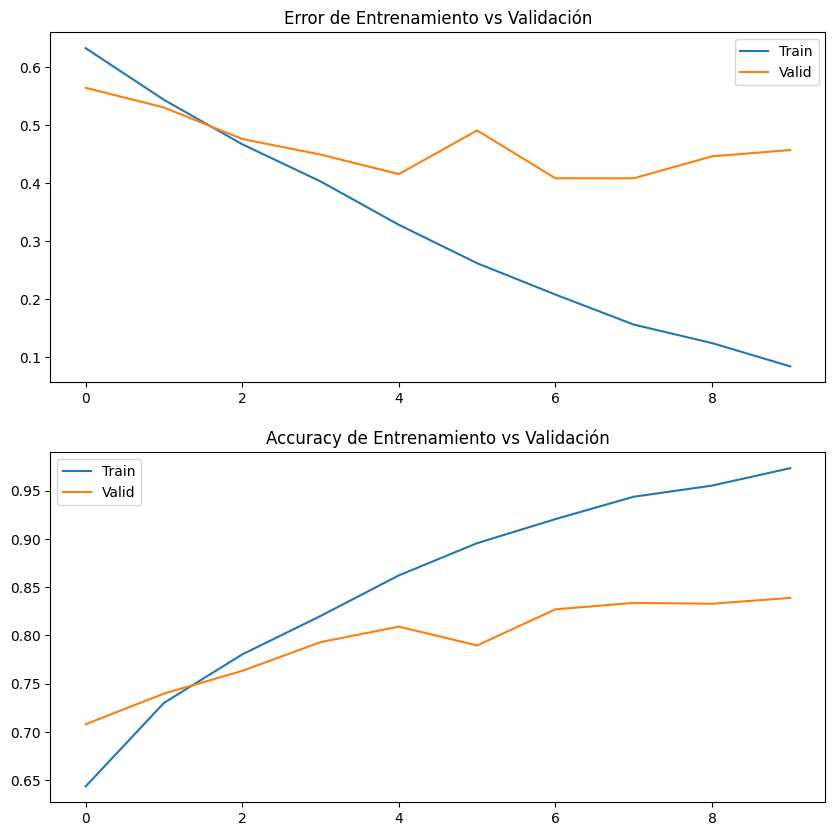

In [16]:
plot_history(history)

Accuracy: 0.8389999866485596
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1500
           1       0.83      0.86      0.84      1500

    accuracy                           0.84      3000
   macro avg       0.84      0.84      0.84      3000
weighted avg       0.84      0.84      0.84      3000



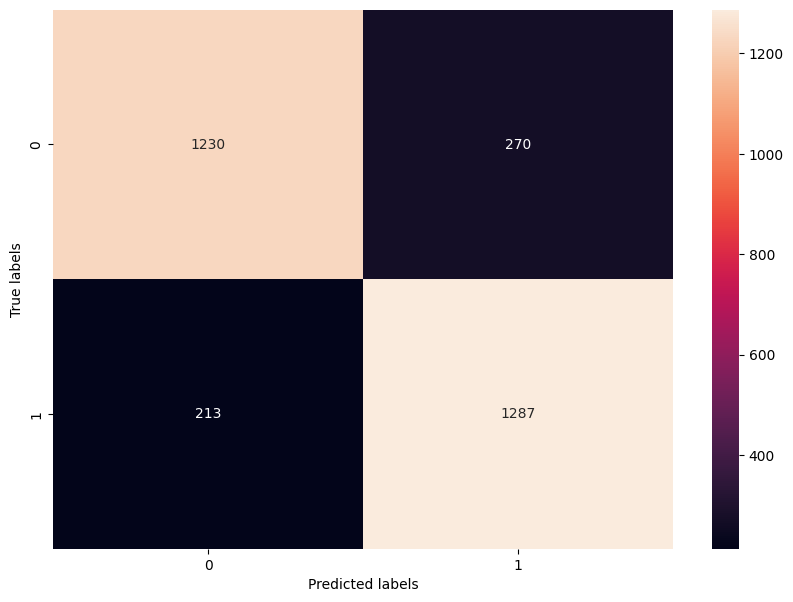

In [35]:
evaluate_model(simple_model, valid_loader, metric)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


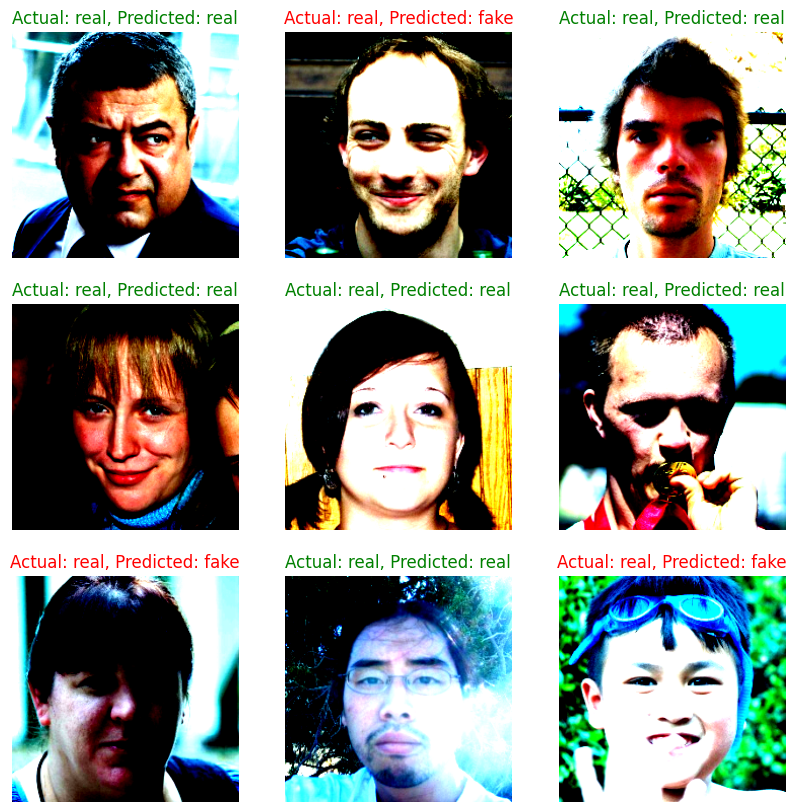

In [49]:
plot_predictions(simple_model, valid_loader)